# TS 2025 - Assignment 2

Before you begin, set the assignment seed to the student id of one of your team members in the cell below.
To choose the data for this set the assignment seed to the student id of one of the team members. The
cell is prefilled with an **example** student id, so make sure to change it and **run the cell** before proceeding
further.

In [1]:
# NB!: change this to the student id of one of your team members

assignment_seed = "2EB0100104"

## Presentation

Do not create powerpoint slides or similar presentations for this assignment. The only submission should be
this Jupyter notebook with the completed code and results.

For the presentation of your results please **only include**:

    - Plots
    - Numeric results
    - Tables of model parameters and summaries

**Do not include**:

    - Text in comments or markdown cells
    - Custom functions in the code
    - if-then-else statements or similar control flow structures
    - Loops (for, while, etc.)
    - Any other code that is not directly related to the assignment tasks
  
**Explanations**

For the presentation you should be able to explain all the steps and be able to answer questions about

- Why you use a specific model/test/plot
- What is shown in the plots and numeric results
- How to interpret the results
  
## Tasks

1. Run the following cell to load your data. It will be stored in the pandas Series `dt`. All time series
are stock prices from the SOFIX index. The data that you should use for the model selection is stored in the
series `train`. The data for testing the forecasts is stored in the series `test`.

2. Adjust the labels and titles of the plots to reflect the stock you are analyzing
3. Your task is to select an ARIMA model for the stock price.
   - Choose the order of differencing based on the ACF/PACF plots and unit root tests (ADF, KPSS)
   - Choose the AR and MA orders based on the ACF/PACF plots and information criteria (AIC, BIC)
4. After selecting the ARIMA model, analyze the residuals
   - Plot the residuals and their ACF/PACF
   - Perform the Ljung-Box test on the residuals
   - Plot the histogram and QQ-plot of the residuals
5. Analyze the volatility of the residuals using an appropriate plot
6. Fit several ARCH/GARCH models to the residuals
   - Plot the conditional volatility
   - Analyze the standardized residuals of the GARCH model (plots, Ljung-Box test, histogram, QQ-plot)
   - Test whether negative and positive shocks have different effects on volatility
  
7. Forecast the stock prices for the test period using the ARIMA model in two ways:
   - By manually differencing the data before fitting the ARIMA model
   - By using the integrated ARIMA model directly
   - Compare the forecasts from both methods and explain the differences, explain the meaning of an
     intercept in the ARIMA model with differenced data
   - Plot the forecasts along with the actual values
   - Compute the RMSE of the forecasts

# Visualisation

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.3/981.3 kB 11.7 MB/s eta 0:00:00


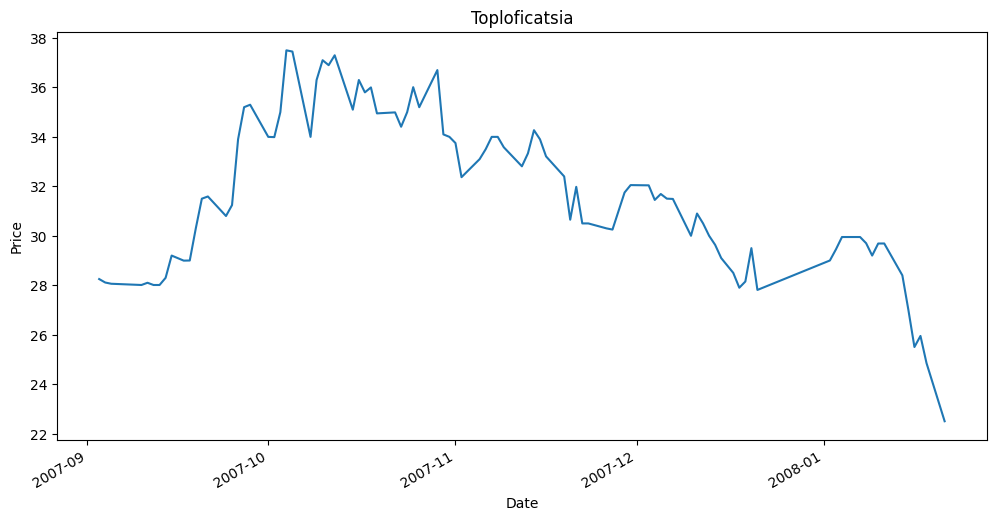

In [2]:
# Import libraries

%pip install arch

import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from arch import arch_model
from scipy import stats
import numpy as np

np.random.seed(int(re.sub(r"\D", "", assignment_seed)))

stocks = pd.read_excel("https://github.com/febse/data/raw/refs/heads/main/ts/SOFIX-Stocks.xlsx", usecols="A:Q").set_index("Date")

dt = stocks[np.random.choice(stocks.columns)]

# Split the data into training and test sets

train_size = int(len(dt) * 0.85)
train, test = dt[:train_size], dt[train_size:]

# Plot the training data

train.plot(title="Stock Price", figsize=(12, 6))

plt.xlabel("Date")
plt.ylabel("Price")
plt.title("Toploficatsia")
plt.show()

In [3]:
train

,TOPL
Date,
2007-09-03,28.250
2007-09-04,28.110
2007-09-05,28.060
2007-09-10,28.010
2007-09-11,28.100
...,...
2008-01-15,27.000
2008-01-16,25.502
2008-01-17,25.950


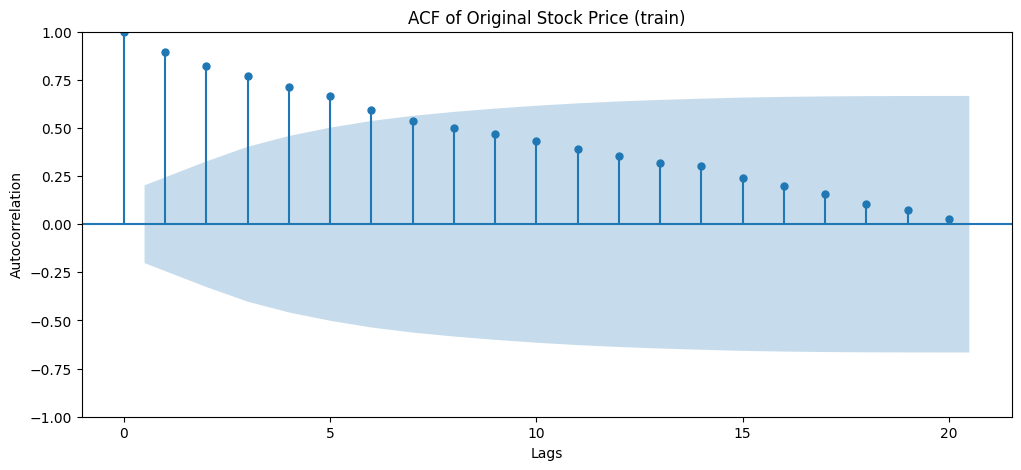

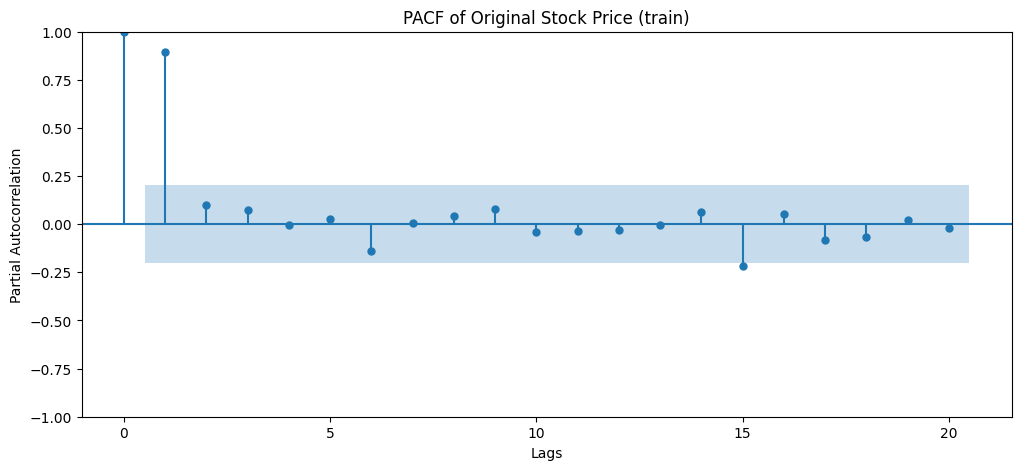

In [4]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF of the original training series
fig, ax = plt.subplots(figsize=(12, 5))
plot_acf(train, ax=ax, lags=20)
ax.set_title('ACF of Original Stock Price (train)')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.show()

# Plot PACF of the original training series
fig, ax = plt.subplots(figsize=(12, 5))
plot_pacf(train, ax=ax, lags=20)
ax.set_title('PACF of Original Stock Price (train)')
plt.xlabel('Lags')
plt.ylabel('Partial Autocorrelation')
plt.show()

In [5]:
from statsmodels.tsa.stattools import adfuller

# ADF test with a constant and a trend
adf_result = adfuller(train, regression='c')

print('ADF Statistic:', adf_result[0])
print('ADF lags:', adf_result[2])
print('p-value:', adf_result[1])
print('Critical Values:')
for key, value in adf_result[4].items():
    print(f'   {key}: {value}')

ADF Statistic: -0.5666071421329789
ADF lags: 5
p-value: 0.8783503457507207
Critical Values:
   1%: -3.506944401824286
   5%: -2.894989819214876
   10%: -2.584614550619835


In [6]:
import numpy as np

# Calculate the natural logarithm of the train series
log_train = np.log(train)

display(log_train.head())

,TOPL
Date,
2007-09-03,3.341093
2007-09-04,3.336125
2007-09-05,3.334345
2007-09-10,3.332562
2007-09-11,3.335770


In [7]:
# Calculate the first differences of the log-transformed training data
log_train_diff = log_train.diff().dropna()

display(log_train_diff.head())

,TOPL
Date,
2007-09-04,-0.004968
2007-09-05,-0.001780
2007-09-10,-0.001783
2007-09-11,0.003208
2007-09-12,-0.003208


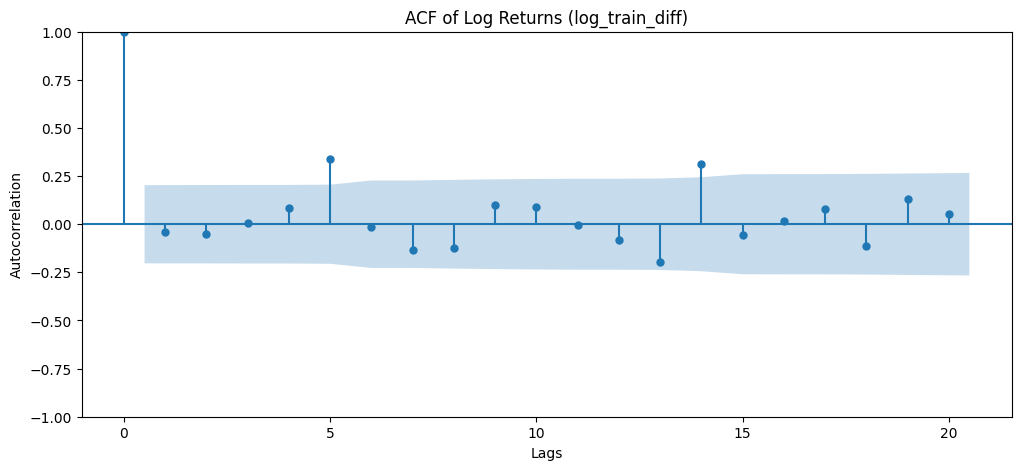

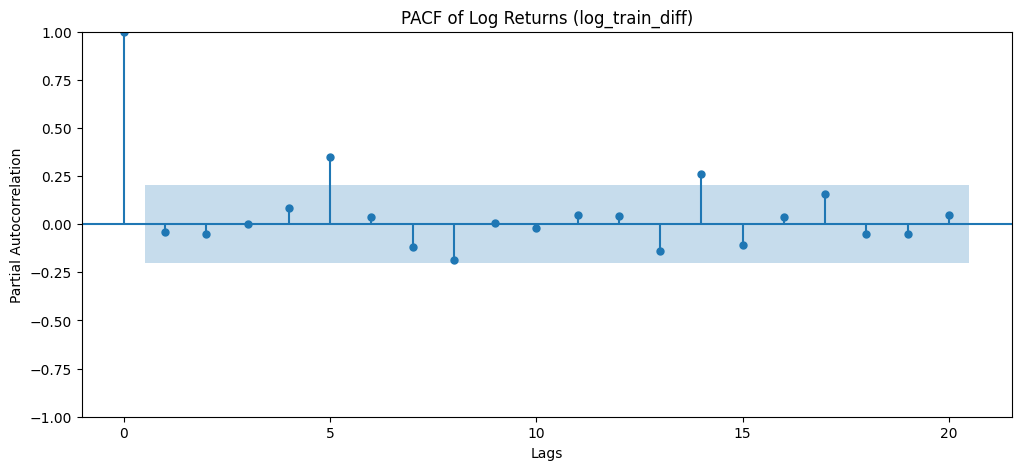

In [8]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF
fig, ax = plt.subplots(figsize=(12, 5))
plot_acf(log_train_diff, ax=ax, lags=20)
ax.set_title('ACF of Log Returns (log_train_diff)')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.show()

# Plot PACF
fig, ax = plt.subplots(figsize=(12, 5))
plot_pacf(log_train_diff, ax=ax, lags=20)
ax.set_title('PACF of Log Returns (log_train_diff)')
plt.xlabel('Lags')
plt.ylabel('Partial Autocorrelation')
plt.show()

In [9]:
from statsmodels.tsa.stattools import adfuller

# ADF test on the log-differenced training data
adf_result_log_diff = adfuller(log_train_diff, regression='c')

print('ADF Statistic (Log Returns):', adf_result_log_diff[0])
print('ADF lags (Log Returns):', adf_result_log_diff[2])
print('p-value (Log Returns):', adf_result_log_diff[1])
print('Critical Values (Log Returns):')
for key, value in adf_result_log_diff[4].items():
    print(f'   {key}: {value}')

ADF Statistic (Log Returns): -1.6227521043947075
ADF lags (Log Returns): 4
p-value (Log Returns): 0.47128677177771283
Critical Values (Log Returns):
   1%: -3.506944401824286
   5%: -2.894989819214876
   10%: -2.584614550619835


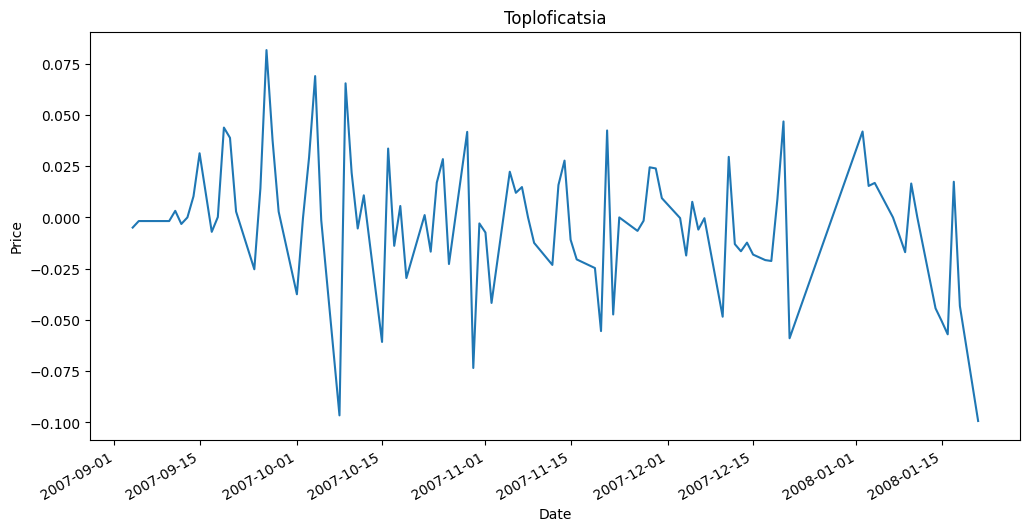

In [10]:
# Plot

log_train_diff.plot(title="Log Returns Plot", figsize=(12, 6))

plt.xlabel("Date")
plt.ylabel("Price")
plt.title("Toploficatsia")
plt.show()

# Levels Transformation

In [11]:
from statsmodels.tsa.arima.model import ARIMA

# Fit an ARIMA(0,1,0) model to the 'log_train' series

arima_model_010 = ARIMA(log_train, order=(0,1,0))
arima_results_010 = arima_model_010.fit()

print(arima_results_010.summary())

                               SARIMAX Results                                
Dep. Variable:                   TOPL   No. Observations:                   94
Model:                 ARIMA(0, 1, 0)   Log Likelihood                 186.936
Date:                Tue, 13 Jan 2026   AIC                           -371.872
Time:                        11:19:00   BIC                           -369.339
Sample:                             0   HQIC                          -370.849
                                 - 94                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0011      0.000      8.302      0.000       0.001       0.001
Ljung-Box (L1) (Q):                   0.16   Jarque-Bera (JB):                 5.16
Prob(Q):                              0.69   Pr

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [12]:
from statsmodels.tsa.arima.model import ARIMA

# Fit an ARIMA(5,1,0) model to the 'log_train' series
arima_model_510 = ARIMA(log_train, order=(5,1,0))
arima_results_510 = arima_model_510.fit()

print(arima_results_510.summary())

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                   TOPL   No. Observations:                   94
Model:                 ARIMA(5, 1, 0)   Log Likelihood                 194.462
Date:                Tue, 13 Jan 2026   AIC                           -376.924
Time:                        11:19:05   BIC                           -361.728
Sample:                             0   HQIC                          -370.788
                                 - 94                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0526      0.089     -0.593      0.553      -0.226       0.121
ar.L2         -0.0158      0.103     -0.154      0.878      -0.217       0.186
ar.L3          0.0351      0.100      0.352      0.7

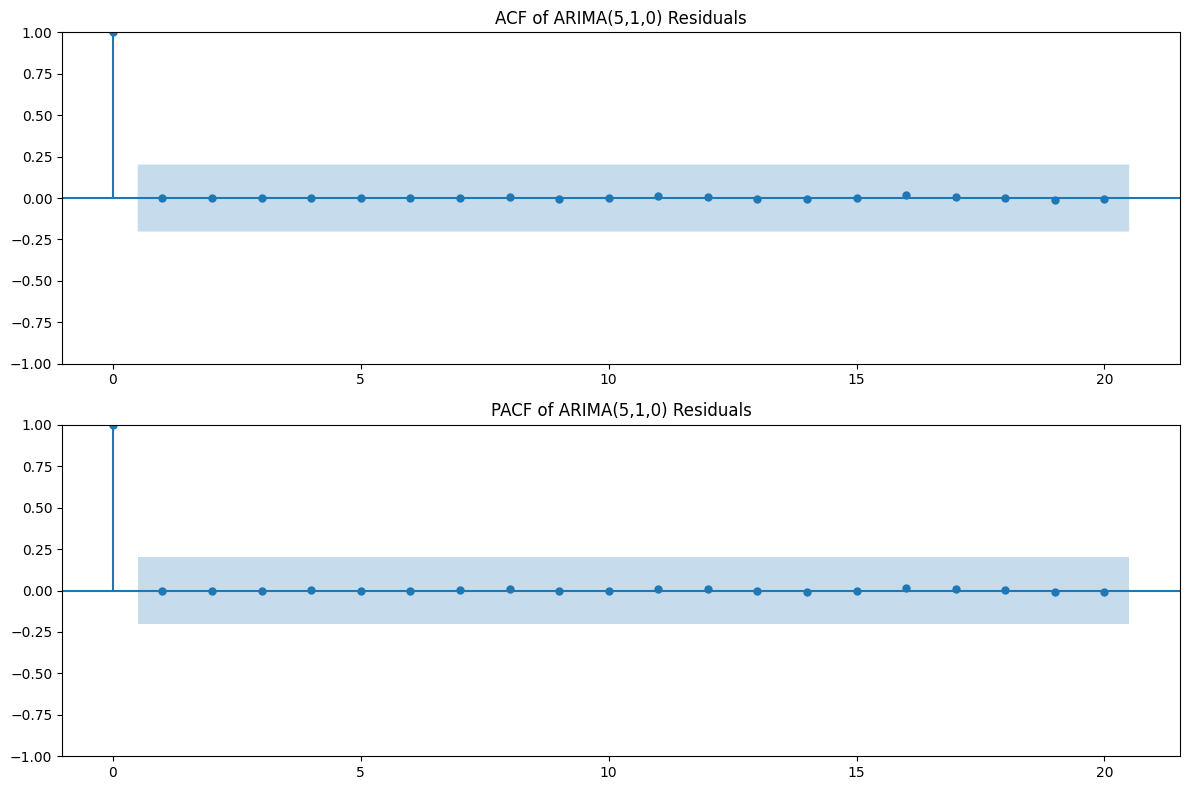

In [13]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

residuals_510 = arima_results_510.resid

# Plot ACF and PACF of the residuals
fig, axes = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(residuals_510, ax=axes[0], lags=20, title='ACF of ARIMA(5,1,0) Residuals')
plot_pacf(residuals_510, ax=axes[1], lags=20, title='PACF of ARIMA(5,1,0) Residuals')
plt.tight_layout()
plt.show()

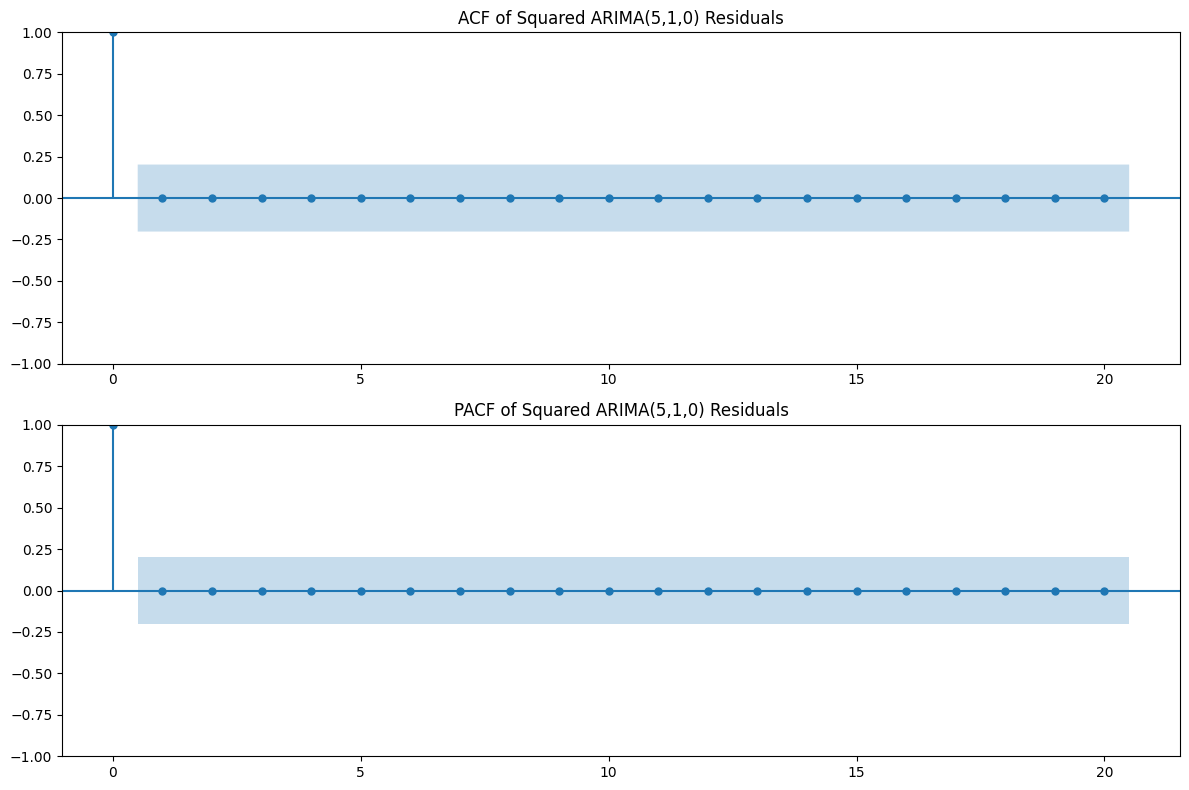

In [18]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

squared_residuals_510 = arima_results_510.resid**2

# Plot ACF and PACF of the squared residuals
fig, axes = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(squared_residuals_510, ax=axes[0], lags=20, title='ACF of Squared ARIMA(5,1,0) Residuals')
plot_pacf(squared_residuals_510, ax=axes[1], lags=20, title='PACF of Squared ARIMA(5,1,0) Residuals')
plt.tight_layout()
plt.show()

In [14]:
from statsmodels.stats.diagnostic import acorr_ljungbox

# Perform the Ljung-Box test on the residuals
ljungbox_test_510 = acorr_ljungbox(residuals_510, lags=[1, 5, 10], return_df=True)
print('Ljung-Box test on ARIMA(5,1,0) Residuals:')
display(ljungbox_test_510)

Ljung-Box test on ARIMA(5,1,0) Residuals:


,lb_stat,lb_pvalue
1,0.000174,0.989469
5,0.000346,1.000000
10,0.009051,1.000000


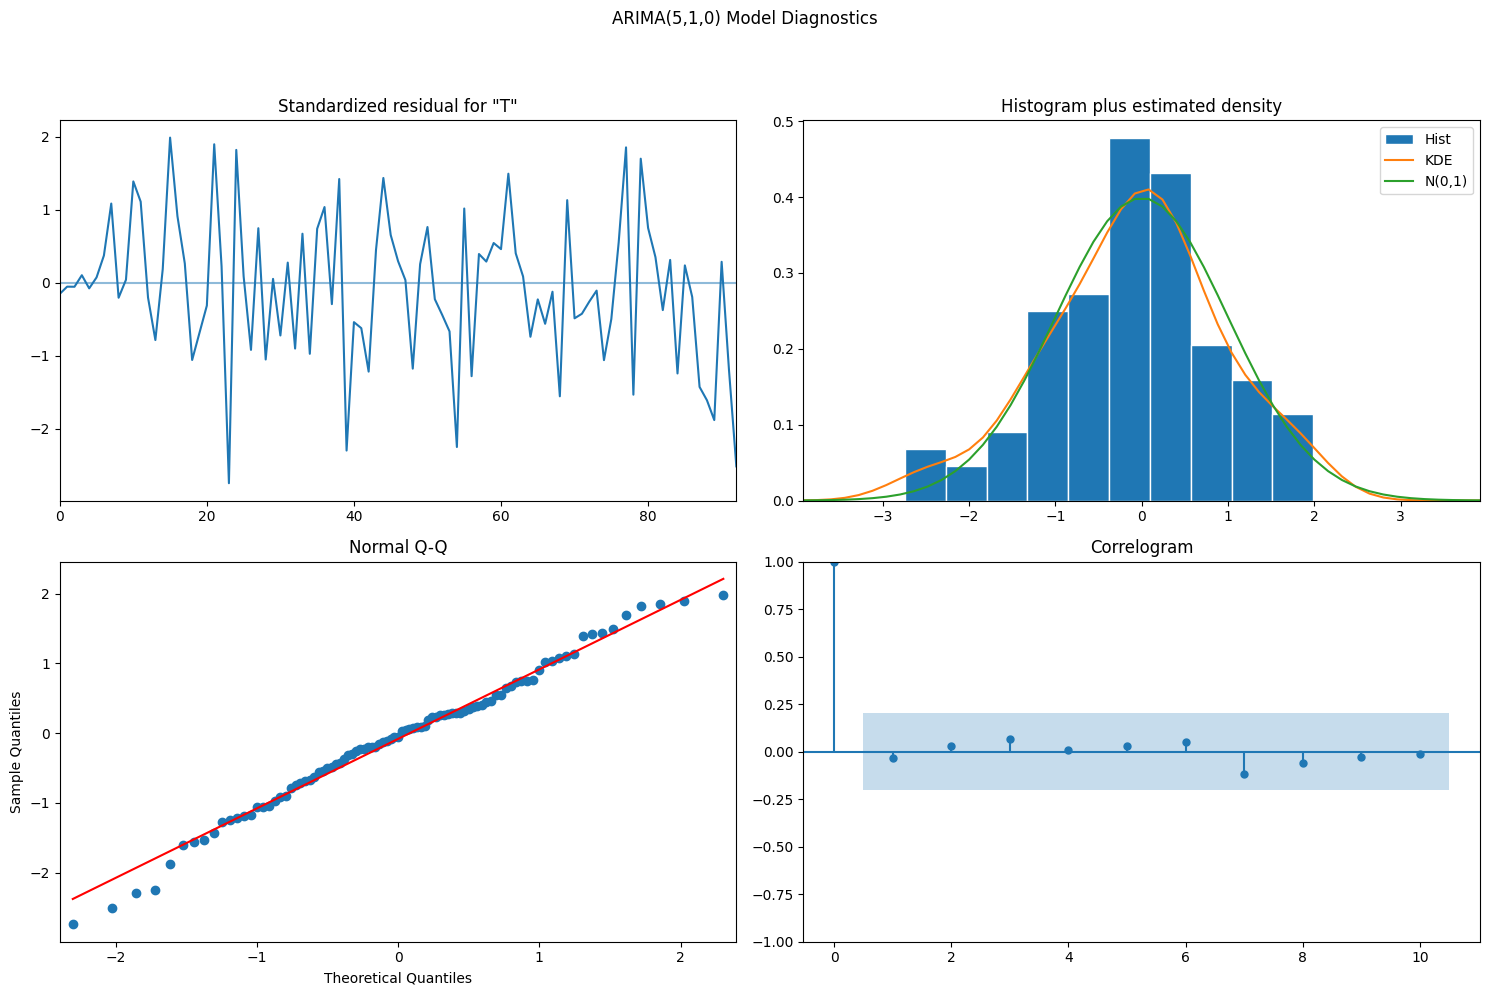

In [15]:
import matplotlib.pyplot as plt

# Generate diagnostic plots for the ARIMA(5,1,0) model residuals
arima_results_510.plot_diagnostics(figsize=(15, 10))
plt.suptitle('ARIMA(5,1,0) Model Diagnostics', y=1.02)
plt.tight_layout(rect=[0, 0.03, 1, 0.98])
plt.show()

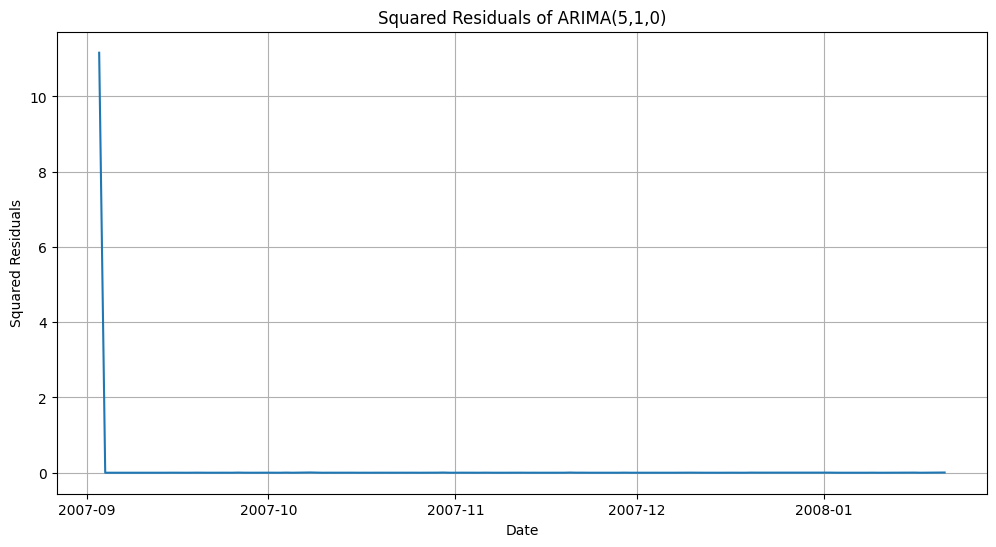

In [16]:
import matplotlib.pyplot as plt

# Squared residuals Plot
plt.figure(figsize=(12, 6))
plt.plot(arima_results_510.resid**2)
plt.title('Squared Residuals of ARIMA(5,1,0)')
plt.xlabel('Date')
plt.ylabel('Squared Residuals')
plt.grid(True)
plt.show()

In [17]:
from arch import arch_model

# Get the residuals from the ARIMA(5,1,0) model
residuals_510 = arima_results_510.resid

# Fit a GARCH(1,1) model to the residuals of the ARIMA(5,1,0) model
garch_model_510_11 = arch_model(residuals_510, p=1, q=1)
garch_results_510_11 = garch_model_510_11.fit(disp='off') # disp='off' to suppress convergence messages

print(garch_results_510_11.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                166.261
Distribution:                  Normal   AIC:                          -324.523
Method:            Maximum Likelihood   BIC:                          -314.349
                                        No. Observations:                   94
Date:                Tue, Jan 13 2026   Df Residuals:                       93
Time:                        11:19:59   Df Model:                            1
                                  Mean Model                                  
                  coef    std err          t      P>|t|       95.0% Conf. Int.
------------------------------------------------------------------------------
mu         -3.4605e-03  3.424e-03     -1.011      0.

In [18]:
from arch import arch_model

residuals_510 = arima_results_510.resid

# Fit a GJR-GARCH(1,1,1) model to the residuals
gjr_garch_model_510 = arch_model(residuals_510, p=1, o=1, q=1)
gjr_garch_results_510 = gjr_garch_model_510.fit(disp='off')

print(gjr_garch_results_510.summary())

                   Constant Mean - GJR-GARCH Model Results                    
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                  GJR-GARCH   Log-Likelihood:                181.906
Distribution:                  Normal   AIC:                          -353.812
Method:            Maximum Likelihood   BIC:                          -341.096
                                        No. Observations:                   94
Date:                Tue, Jan 13 2026   Df Residuals:                       93
Time:                        11:20:08   Df Model:                            1
                                   Mean Model                                  
                  coef    std err          t      P>|t|        95.0% Conf. Int.
-------------------------------------------------------------------------------
mu         -6.7252e-03  2.970e-03     -2.265  2.3

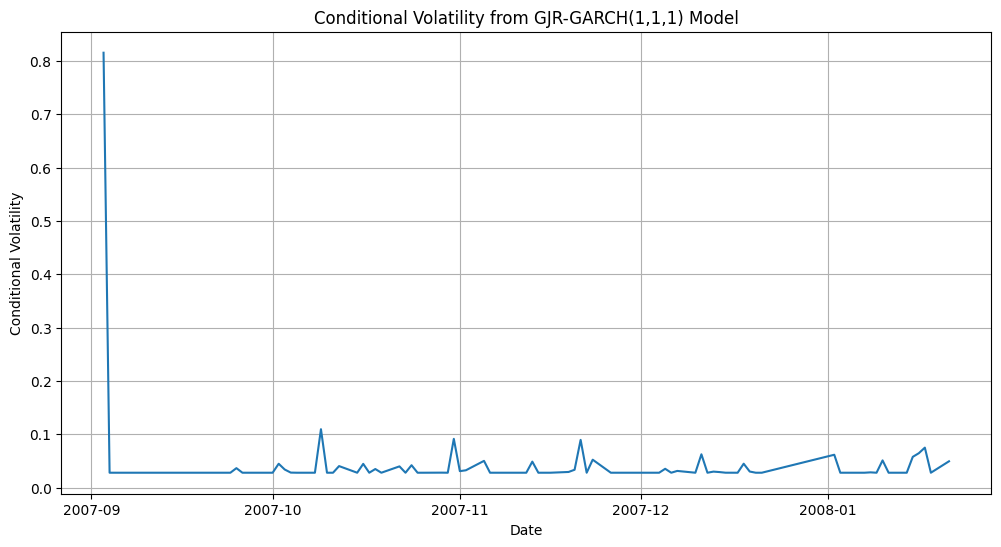

In [19]:
import matplotlib.pyplot as plt

# Conditional volatility from the GJR-GARCH model
plt.figure(figsize=(12, 6))
plt.plot(gjr_garch_results_510.conditional_volatility)
plt.title('Conditional Volatility from GJR-GARCH(1,1,1) Model')
plt.xlabel('Date')
plt.ylabel('Conditional Volatility')
plt.grid(True)
plt.show()

# Log Returns

In [20]:
from statsmodels.tsa.arima.model import ARIMA

# Fit an ARIMA(1,0,0) model to the log_train_diff series
# The order (1,0,0) means:
# p=1 (1 AR term)
# d=0 (no further differencing, as the data is already differenced)
# q=0 (no MA terms)
arima_model_100_log_diff = ARIMA(log_train_diff, order=(1,0,0))
arima_results_100_log_diff = arima_model_100_log_diff.fit()

print(arima_results_100_log_diff.summary())

                               SARIMAX Results                                
Dep. Variable:                   TOPL   No. Observations:                   93
Model:                 ARIMA(1, 0, 0)   Log Likelihood                 187.287
Date:                Tue, 13 Jan 2026   AIC                           -368.574
Time:                        11:20:51   BIC                           -360.976
Sample:                             0   HQIC                          -365.506
                                 - 93                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0024      0.003     -0.729      0.466      -0.009       0.004
ar.L1         -0.0453      0.089     -0.508      0.612      -0.220       0.130
sigma2         0.0010      0.000      7.926      0.0

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [22]:
from statsmodels.tsa.arima.model import ARIMA

# Fit an ARIMA(0,0,0) model to the log_train_diff series
arima_model_000_log_diff = ARIMA(log_train_diff, order=(0,0,0))
arima_results_000_log_diff = arima_model_000_log_diff.fit()

print(arima_results_000_log_diff.summary())

                               SARIMAX Results                                
Dep. Variable:                   TOPL   No. Observations:                   93
Model:                          ARIMA   Log Likelihood                 187.202
Date:                Tue, 13 Jan 2026   AIC                           -370.403
Time:                        11:21:49   BIC                           -365.338
Sample:                             0   HQIC                          -368.358
                                 - 93                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0025      0.003     -0.712      0.476      -0.009       0.004
sigma2         0.0010      0.000      7.936      0.000       0.001       0.001
Ljung-Box (L1) (Q):                   0.16   Jarque-

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [23]:
from statsmodels.tsa.arima.model import ARIMA

# Fit an ARIMA(5,0,0) model to the log_train_diff series
arima_model_500_log_diff = ARIMA(log_train_diff, order=(5,0,0))
arima_results_500_log_diff = arima_model_500_log_diff.fit()

print(arima_results_500_log_diff.summary())

                               SARIMAX Results                                
Dep. Variable:                   TOPL   No. Observations:                   93
Model:                 ARIMA(5, 0, 0)   Log Likelihood                 194.759
Date:                Tue, 13 Jan 2026   AIC                           -375.519
Time:                        11:21:52   BIC                           -357.790
Sample:                             0   HQIC                          -368.360
                                 - 93                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0045      0.006     -0.710      0.478      -0.017       0.008
ar.L1         -0.0565      0.088     -0.639      0.523      -0.230       0.117
ar.L2         -0.0182      0.105     -0.173      0.8

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


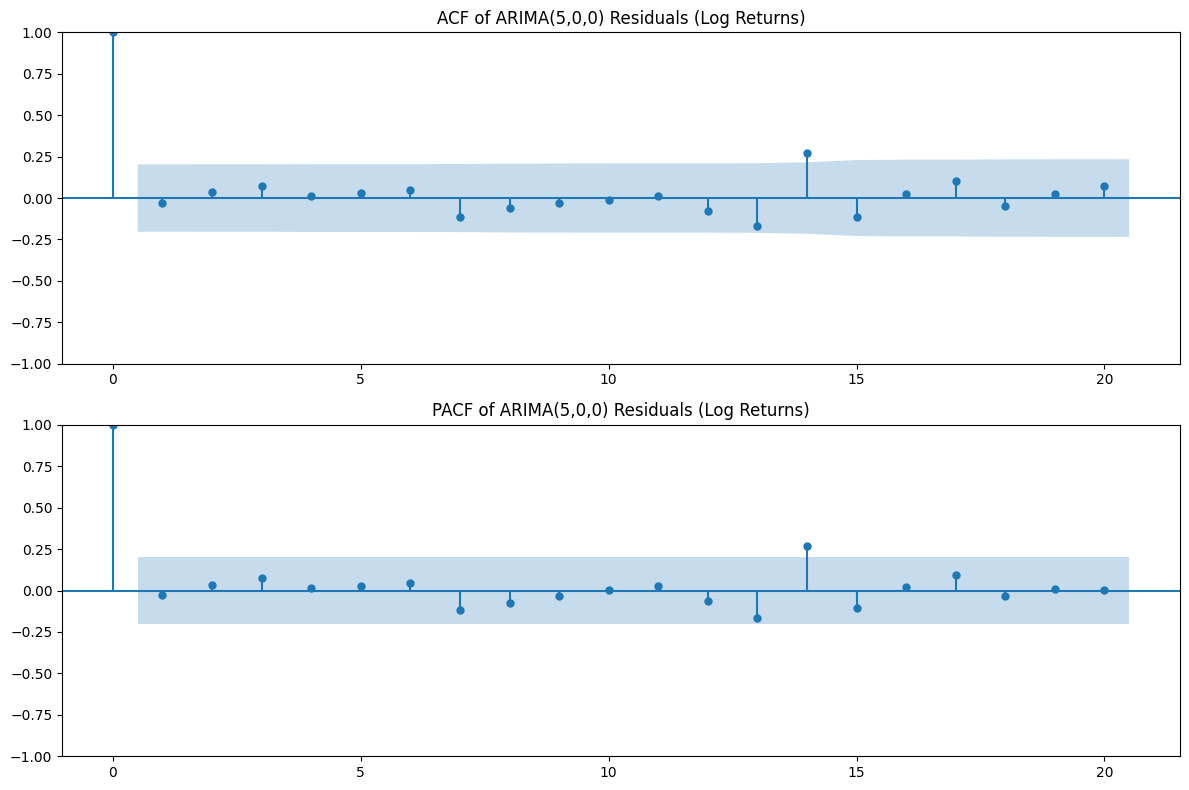

In [24]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.gofplots import qqplot
import seaborn as sns

# Residuals from the ARIMA(0,0,0) model on log_train_diff
residuals_500_log_diff = arima_results_500_log_diff.resid

# 1. Plot ACF and PACF of the residuals
fig, axes = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(residuals_500_log_diff, ax=axes[0], lags=20, title='ACF of ARIMA(5,0,0) Residuals (Log Returns)')
plot_pacf(residuals_500_log_diff, ax=axes[1], lags=20, title='PACF of ARIMA(5,0,0) Residuals (Log Returns)')
plt.tight_layout()
plt.show()

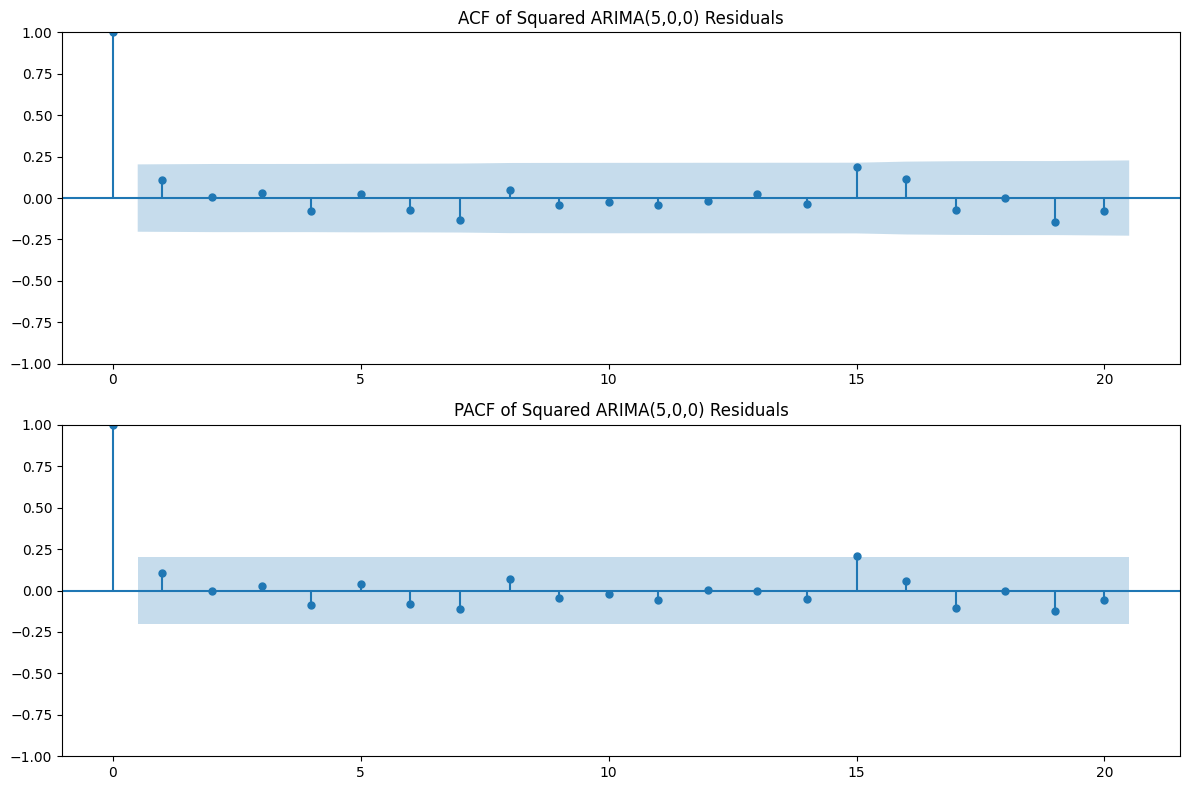

In [25]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Squared residuals from the ARIMA(5,1,0) model
squared_residuals_500 = arima_results_500_log_diff.resid**2

# Plot ACF and PACF of the squared residuals
fig, axes = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(squared_residuals_500, ax=axes[0], lags=20, title='ACF of Squared ARIMA(5,0,0) Residuals')
plot_pacf(squared_residuals_500, ax=axes[1], lags=20, title='PACF of Squared ARIMA(5,0,0) Residuals')
plt.tight_layout()
plt.show()

In [26]:
# 2. Perform the Ljung-Box test on the residuals
ljungbox_test = acorr_ljungbox(residuals_500_log_diff, lags=[1, 5, 10], return_df=True)
print('Ljung-Box test on ARIMA(5,0,0) Residuals (Log Returns):')
display(ljungbox_test)

Ljung-Box test on ARIMA(5,0,0) Residuals (Log Returns):


,lb_stat,lb_pvalue
1,0.078424,0.779445
5,0.813603,0.976158
10,2.857761,0.984576


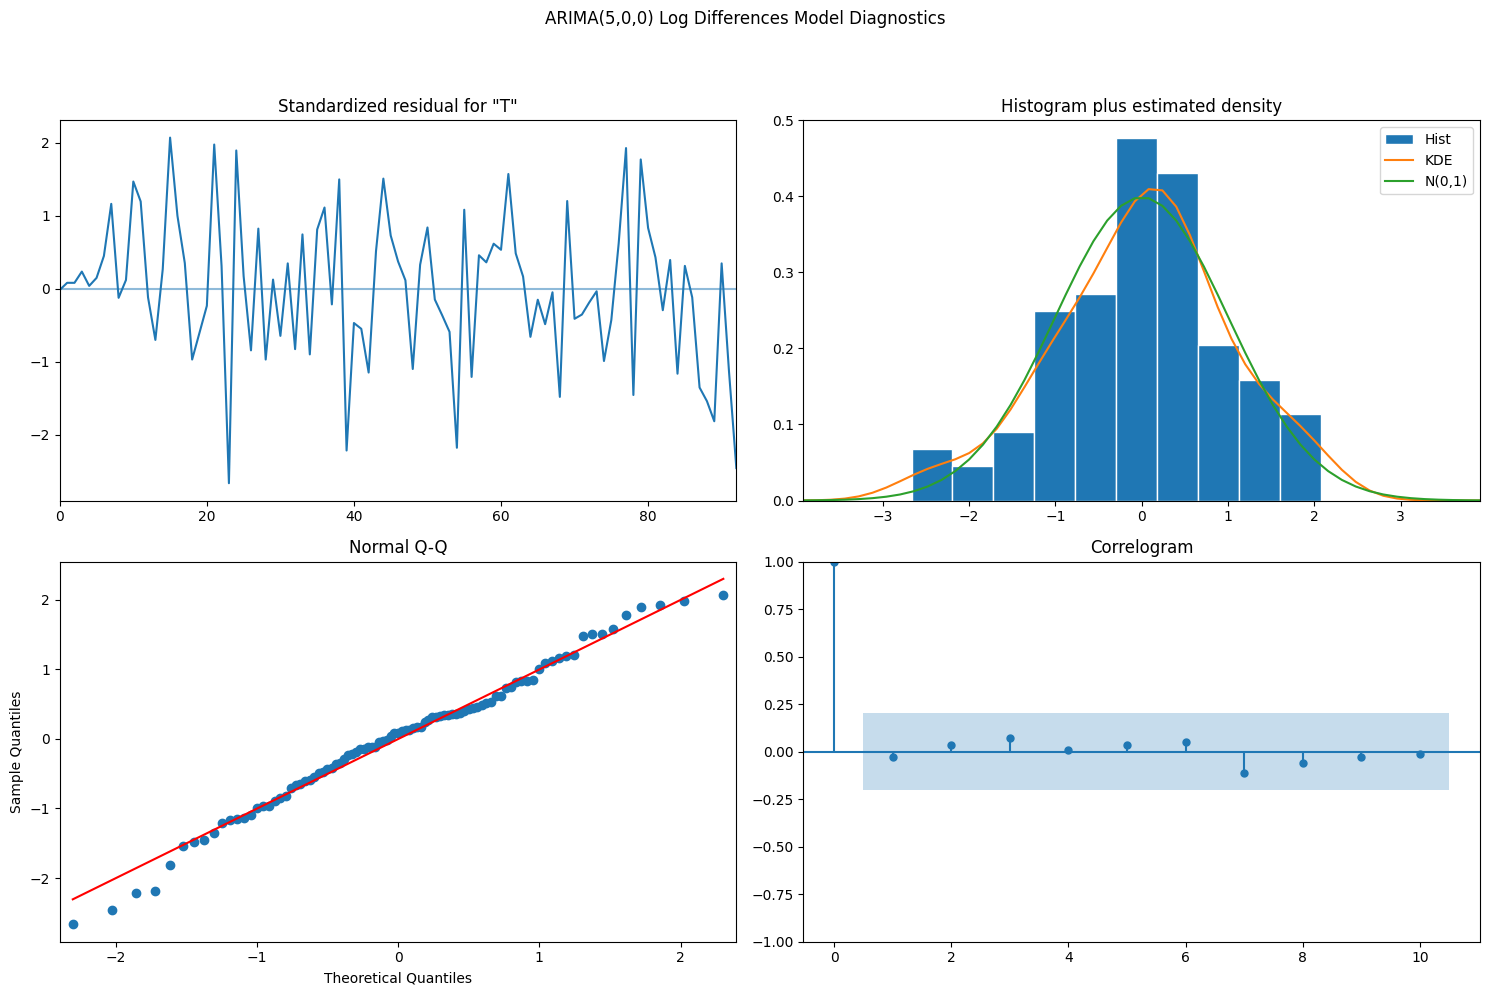

In [27]:
import matplotlib.pyplot as plt

# Generate diagnostic plots for the ARIMA(5,0,0) model residuals
arima_results_500_log_diff.plot_diagnostics(figsize=(15, 10))
plt.suptitle('ARIMA(5,0,0) Log Differences Model Diagnostics', y=1.02)
plt.tight_layout(rect=[0, 0.03, 1, 0.98])
plt.show()

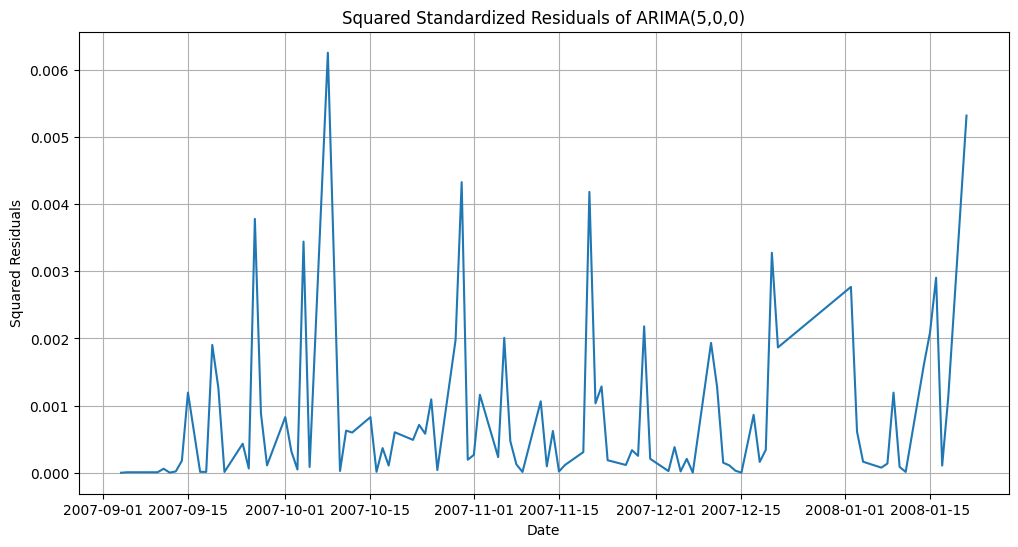

In [28]:
import matplotlib.pyplot as plt

# Plot the squared standardized residuals to visualize volatility
plt.figure(figsize=(12, 6))


plt.plot(arima_results_500_log_diff.resid**2)
plt.title('Squared Standardized Residuals of ARIMA(5,0,0)')
plt.xlabel('Date')
plt.ylabel('Squared Residuals')
plt.grid(True)
plt.show()

In [29]:
from arch import arch_model

# Fit a GARCH(1,1) model to the residuals of the ARIMA(5,0,0) model
garch_model_11 = arch_model(residuals_500_log_diff, p=1, q=1)
garch_results_11 = garch_model_11.fit(disp='off') # disp='off' to suppress convergence messages

# Display the model summary
print(garch_results_11.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                195.953
Distribution:                  Normal   AIC:                          -383.906
Method:            Maximum Likelihood   BIC:                          -373.776
                                        No. Observations:                   93
Date:                Tue, Jan 13 2026   Df Residuals:                       92
Time:                        11:22:55   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         3.4595e-04  3.107e-03      0.111      0.911 

/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008794. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)


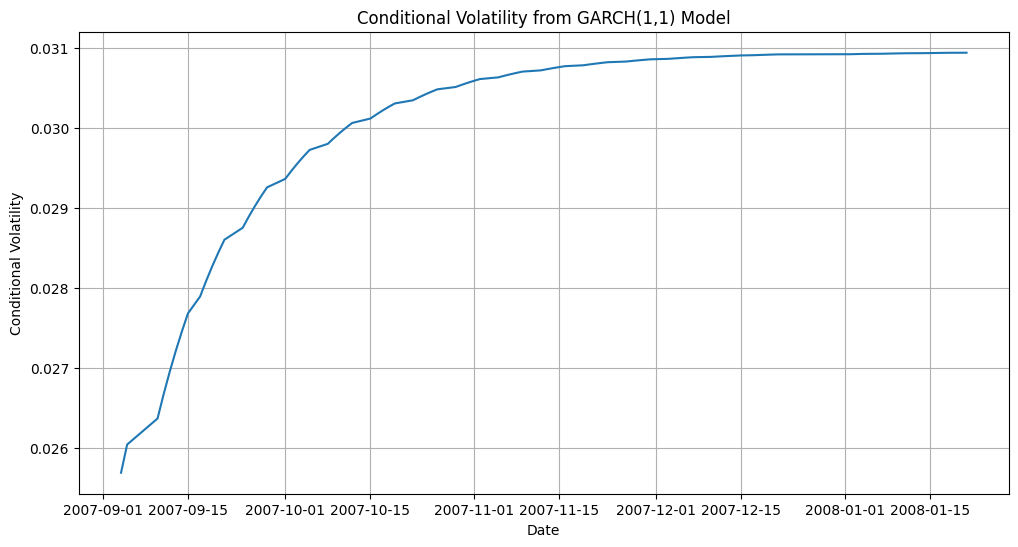

In [30]:
import matplotlib.pyplot as plt

# Plot the conditional volatility from the GARCH(1,1) model
plt.figure(figsize=(12, 6))
plt.plot(garch_results_11.conditional_volatility)
plt.title('Conditional Volatility from GARCH(1,1) Model')
plt.xlabel('Date')
plt.ylabel('Conditional Volatility')
plt.grid(True)
plt.show()

In [31]:
from statsmodels.stats.diagnostic import acorr_ljungbox

# Get the standardized residuals from the GARCH(1,1) model
standardized_residuals_garch_11 = garch_results_11.resid / garch_results_11.conditional_volatility

# Perform the Ljung-Box test on the standardized residuals
ljungbox_test_garch_11 = acorr_ljungbox(standardized_residuals_garch_11, lags=[1, 5, 10], return_df=True)
print('Ljung-Box test on Standardized Residuals of GARCH(1,1) model:')
display(ljungbox_test_garch_11)

Ljung-Box test on Standardized Residuals of GARCH(1,1) model:


,lb_stat,lb_pvalue
1,0.060719,0.805363
5,0.805510,0.976681
10,2.793088,0.985883


# Forecast

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


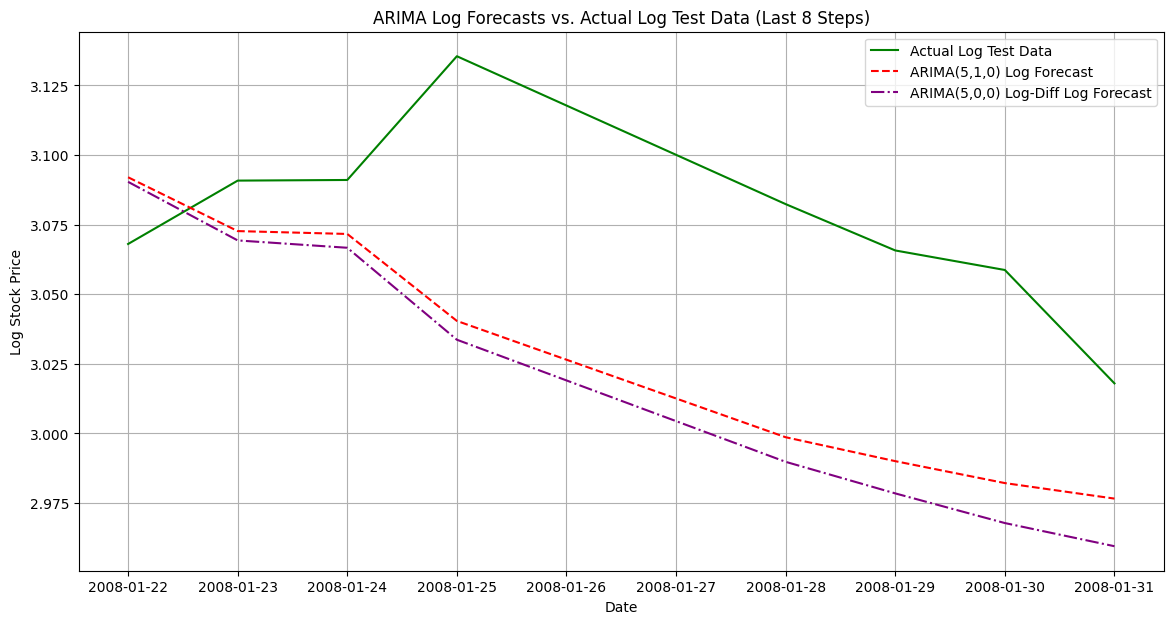

In [32]:
from sklearn.metrics import mean_squared_error
import numpy as np

forecast_steps = 8

# Get the actual test data for the comparison period
test_actual = test.dropna()
log_test_actual = np.log(test_actual)

# Forecast with ARIMA(5,1,0)
forecast_arima_510 = arima_results_510.get_forecast(steps=forecast_steps)
predicted_mean_510 = forecast_arima_510.predicted_mean
predicted_mean_510.index = log_test_actual.index

# Forecast with ARIMA(5,0,0)
forecast_log_diff_500 = arima_results_500_log_diff.get_forecast(steps=forecast_steps)
predicted_log_diff_mean_500 = forecast_log_diff_500.predicted_mean
predicted_log_diff_mean_500.index = log_test_actual.index

last_log_train_value = log_train.iloc[-1]
cumulative_log_diff_forecast = predicted_log_diff_mean_500.cumsum()
log_price_forecast_500 = last_log_train_value + cumulative_log_diff_forecast
log_price_forecast_500.index = log_test_actual.index

# Plotting the forecasts
plt.figure(figsize=(14, 7))
# Plot the actual log test data and the log forecasts
plt.plot(log_test_actual.index, log_test_actual, label='Actual Log Test Data', color='green')
plt.plot(predicted_mean_510.index, predicted_mean_510, label='ARIMA(5,1,0) Log Forecast', color='red', linestyle='--')
plt.plot(log_price_forecast_500.index, log_price_forecast_500, label='ARIMA(5,0,0) Log-Diff Log Forecast', color='purple', linestyle='-.')

plt.title('ARIMA Log Forecasts vs. Actual Log Test Data (Last 8 Steps)')
plt.xlabel('Date')
plt.ylabel('Log Stock Price')
plt.legend()
plt.grid(True)
plt.show()

In [33]:
# Calculate RMSE
rmse_arima_510 = np.sqrt(mean_squared_error(log_test_actual, predicted_mean_510))
rmse_arima_500_log_diff = np.sqrt(mean_squared_error(log_test_actual, log_price_forecast_500))

print(f"RMSE for ARIMA(5,1,0) log forecast: {rmse_arima_510:.4f}")
print(f"RMSE for ARIMA(5,0,0) (Log-Differenced) log forecast: {rmse_arima_500_log_diff:.4f}")

RMSE for ARIMA(5,1,0) log forecast: 0.0619
RMSE for ARIMA(5,0,0) (Log-Differenced) log forecast: 0.0705
